In [1]:
#dependencies for BERT
# !pip install folium==0.2.1
# !pip install tqdm boto3 requests regex sentencepiece sacremoses --quiet
# !pip install pytorch-lightning==1.2.8 --quiet
# !pip install transformers==4.10.2 --quiet

In [2]:
!nvidia-smi

Thu Dec  2 04:23:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:0D:00.0  On |                  N/A |
|  0%   27C    P8    30W / 320W |   1020MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import pandas as pd
import numpy as np
import re
import gc

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc


In [4]:
from utils import *

# Preprocessing

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/zappocalypse/jubilant-meme/main/mbti_3_compressed.csv")
# df = df.iloc[:500 , 1:]
df = df[["type", "spell_corrected", "is_I","is_E","is_N","is_S","is_F","is_T","is_J","is_P"]]
df = df.rename({'spell_corrected': 'posts'}, axis=1)
df.head()

,type,posts,is_I,is_E,is_N,is_S,is_F,is_T,is_J,is_P
0,INFJ,and into moments sportscaster not top ten play...,1,0,1,0,1,0,1,0
1,ENTP,i m finding the lack of me in these posts very...,0,1,1,0,0,1,0,1
2,INTP,good one course to which i say i know that s m...,1,0,1,0,0,1,0,1
3,INTJ,dear into i enjoyed our conversation the other...,1,0,1,0,0,1,1,0
4,ENTJ,you re fired that s another silly misconceptio...,0,1,1,0,0,1,1,0


<AxesSubplot:>

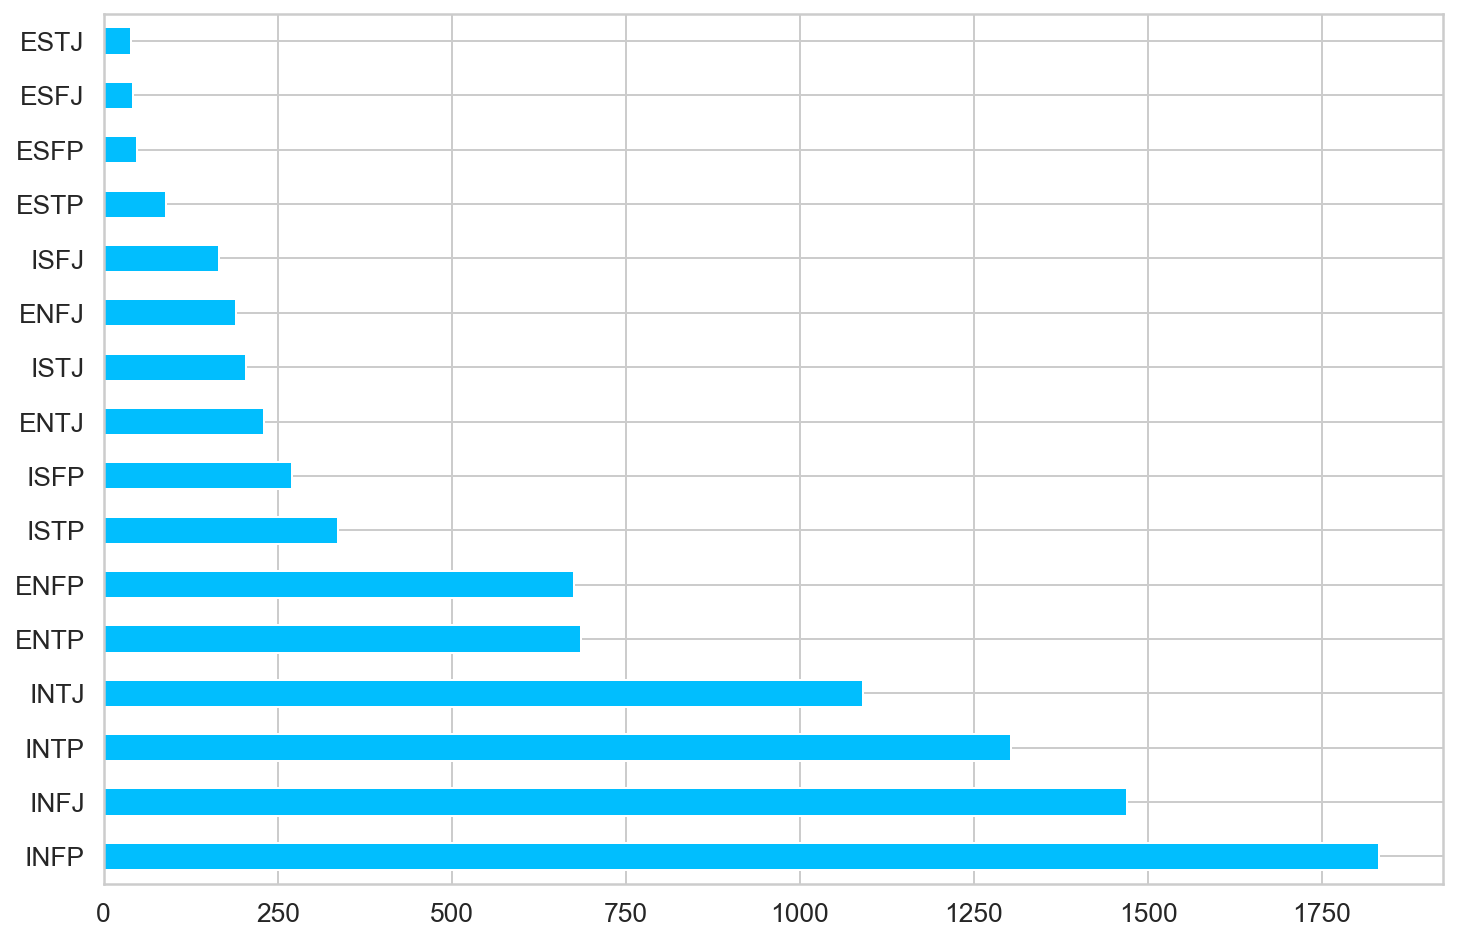

In [7]:
df['type'].value_counts().plot(kind="barh")

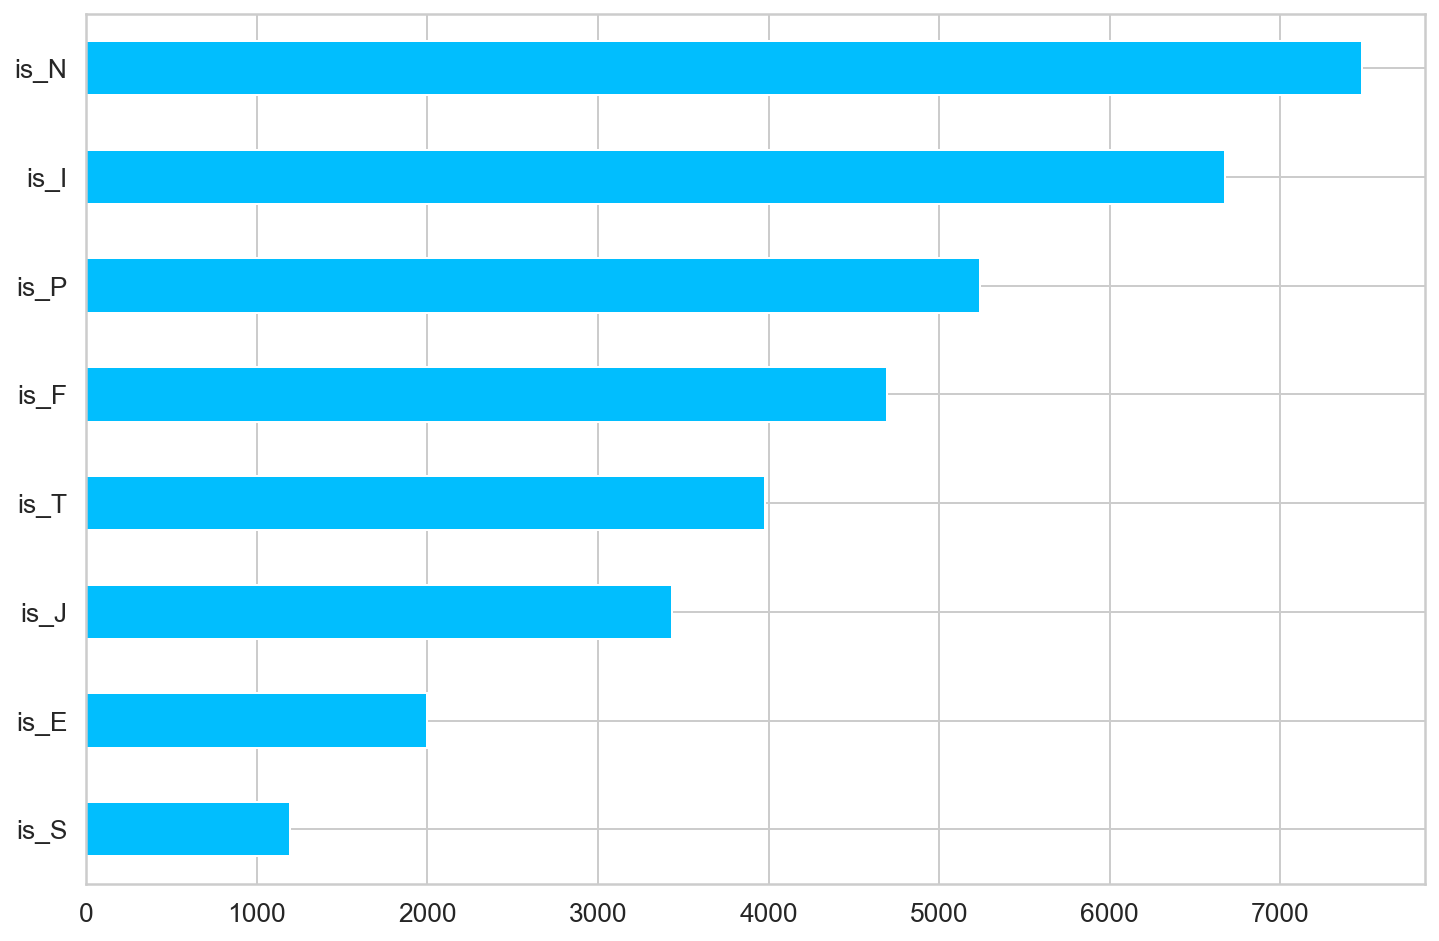

In [8]:
label_cols = df.columns.tolist()[2:]
df[label_cols].sum().sort_values().plot(kind="barh");

In [9]:
df['cleaned_posts'], post_length = clear_text(df)
df.drop(columns=['is_E', 'is_S', 'is_F', 'is_P', 'posts'], inplace=True)

df.head()

,type,is_I,is_N,is_T,is_J,cleaned_posts
0,INFJ,1,1,0,1,and into moments sportscaster not top ten play...
1,ENTP,0,1,1,0,i m finding the lack of me in these posts very...
2,INTP,1,1,1,0,good one course to which i say i know that s m...
3,INTJ,1,1,1,1,dear into i enjoyed our conversation the other...
4,ENTJ,0,1,1,1,you re fired that s another silly misconceptio...


In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.cleaned_posts, df.iloc[:,1:5], random_state=2021, 
                                                    test_size=0.3, stratify=df.type)
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_test, y_test], axis=1)

print(train_df.is_I.sum()/train_df.shape[0], val_df.is_I.sum()/val_df.shape[0] )

print(train_df.head())
print(val_df.head())

0.7697628458498024 0.7691125624279678
                                          cleaned_posts  is_I  is_N  is_T  \
7585  location change whoop colorado you re crazy so...     1     1     0   
7430  maybe you are into and fi would fit you try it...     1     1     1   
3745  note you re not alone i m a singer and i love ...     1     0     1   
2599  i would gently prod for more information next ...     1     1     1   
8035  i bet you it was lucid too bach s cello suite ...     1     1     1   

      is_J  
7585     0  
7430     0  
3745     1  
2599     0  
8035     1  
                                          cleaned_posts  is_I  is_N  is_T  \
7330  i m extremely creative writing cooling music o...     1     1     1   
4409  ethical intuitive extratim wikisocion this is ...     0     1     0   
2839  you know i ve never dated and ist may not even...     0     1     0   
7274  dunno if this will contribute to the discussio...     0     1     1   
1112  to answer your question yes pe

# Using PyTorch
Basic Implementation
https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/


## Tokenization

In [11]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
label_cols = ['is_I','is_N', 'is_T', 'is_J']

### Testing Hyperparameters

In [12]:
# sample_row = df.iloc[16]
# sample_comment = sample_row.cleaned_posts
# sample_labels = sample_row.iloc[:-1]
# print(sample_comment)
# print(sample_labels.to_dict())

In [13]:
max_len = 512
# # Note: maxlen supported by BERT is 512, which means over-truncating much of the data
# # consider using Longformer instead

# encoding = tokenizer.encode_plus(
#   sample_comment,
#   add_special_tokens=True,
#   max_length=max_len,
#   return_token_type_ids=False,
#   padding="max_length",
#   return_attention_mask=True,
#   return_tensors='pt',
# )

# token_counts = []

# for _, row in train_df.iterrows():
#   # specify max no. of tokens in encoding (max is 512)
#     token_count = len(tokenizer.encode(
#     row["cleaned_posts"], 
#     max_length=max_len, 
#     truncation=True
#     ))
#     token_counts.append(token_count)

# print(encoding.keys())
# print(encoding["input_ids"].shape, encoding["attention_mask"].shape)

In [14]:
# sns.histplot(token_counts)
# plt.xlim([0, max_len]);

### Tokenize Datasets

In [15]:
label_cols = ['is_I', 'is_N', 'is_T', 'is_J']

train_dataset = MBTIDataset(
    label_cols,
    train_df,
    tokenizer,
    max_token_len=max_len,
)

sample_item = train_dataset[0]
# print(sample_item.keys(), sample_item['cleaned_posts'])
print(sample_item['labels'], sample_item['input_ids'].shape)


tensor([1., 1., 0., 0.]) torch.Size([512])


In [16]:
# sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
# print(sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape)

# output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])
# print(output.last_hidden_state.shape, output.pooler_output.shape)
# print(bert_model.config.hidden_size)

In [17]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
N_EPOCHS = 10
BATCH_SIZE = 8
label_cols = ['is_I', 'is_N', 'is_T', 'is_J']
max_len = 512

data_module = MBTIDataModule(
  train_df,
  val_df,
  tokenizer,
  label_cols,
  batch_size=BATCH_SIZE,
  max_token_len=max_len
)

# Model

In [19]:
# create model instance

steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

# 20% for warmup
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

model = MBTITagger(
  n_classes=len(label_cols),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
# optimizer changes and optimizes learning rate during training
optimizer = AdamW(params=model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)


learning_rate_history = []

for step in range(total_training_steps):
    optimizer.step()
    scheduler.step()
    learning_rate_history.append(optimizer.param_groups[0]['lr'])

In [21]:
# plt.plot(learning_rate_history, label="learning rate")
# plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
# plt.legend()
# plt.xlabel("Step")
# plt.ylabel("Learning rate")
# plt.tight_layout();

# Training

In [22]:
!rd /s /q "lightning_logs/"
!rd /s /q "checkpoints/"

Invalid switch - "".
Invalid switch - "".


In [23]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

Reusing TensorBoard on port 6006 (pid 17316), started 0:14:01 ago. (Use '!kill 17316' to kill it.)

In [24]:
# Build standard pipeline
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)


# log in dashboard
logger = TensorBoardLogger("lightning_logs", name="mbti-classification")

# early stopping 
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

In [25]:
torch.cuda.empty_cache()
gc.collect()
torch.cuda.memory_summary(device=None, abbreviated=False)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

N_EPOCHS = 50

# train
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=10,
  accumulate_grad_batches=10
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [26]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 3.1 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.253   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

C:\Users\Miles\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\utilities\distributed.py:68: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)


Validating: 0it [00:00, ?it/s]

Epoch 0, global step 75: val_loss reached 0.67740 (best 0.67740), saving model to "C:\Users\Miles\Documents\CDS\checkpoints\best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 151: val_loss reached 0.57721 (best 0.57721), saving model to "C:\Users\Miles\Documents\CDS\checkpoints\best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 227: val_loss reached 0.56917 (best 0.56917), saving model to "C:\Users\Miles\Documents\CDS\checkpoints\best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 303: val_loss reached 0.56254 (best 0.56254), saving model to "C:\Users\Miles\Documents\CDS\checkpoints\best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 379: val_loss reached 0.52402 (best 0.52402), saving model to "C:\Users\Miles\Documents\CDS\checkpoints\best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 455: val_loss reached 0.49892 (best 0.49892), saving model to "C:\Users\Miles\Documents\CDS\checkpoints\best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, step 531: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 607: val_loss reached 0.47758 (best 0.47758), saving model to "C:\Users\Miles\Documents\CDS\checkpoints\best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, step 683: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 759: val_loss reached 0.46858 (best 0.46858), saving model to "C:\Users\Miles\Documents\CDS\checkpoints\best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, step 835: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, step 911: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, step 987: val_loss was not in top 1


1

In [27]:
# test
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.46857842803001404}
--------------------------------------------------------------------------------


[{'test_loss': 0.46857842803001404}]

In [28]:
trained_model = MBTITagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(label_cols)
)

torch.save(trained_model.state_dict(), './BERT/state_dict.pt')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Predict

In [29]:
trained_model.eval()
trained_model.freeze()

In [30]:
# Test a sample
test_comment = "Hi, I'm Meredith and I'm an alch... good at supplier relations"

encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=max_len,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(label_cols, test_prediction):
    print(f"{label}: {prediction}")

is_I: 0.6548576354980469
is_N: 0.5303342342376709
is_T: 0.6782060265541077
is_J: 0.5680252909660339


In [31]:
# second test example

THRESHOLD = 0.5

test_comment = "You are such a loser! You'll regret everything you've done to me!"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=max_len,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(label_cols, test_prediction):
    if prediction < THRESHOLD:
        continue
    print(f"{label}: {prediction}")

is_I: 0.5826546549797058
is_T: 0.6673527359962463


# Evaluation

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = MBTIDataset(
    label_cols,
    val_df,
    tokenizer,
    max_token_len=max_len
)

predictions = []
labels = []

for item in tqdm(val_dataset):
    _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
    )
    predictions.append(prediction.flatten())
    labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

print('Accuracy:')
print(accuracy(predictions, labels, threshold=THRESHOLD))
print("AUROC per tag")
for i, name in enumerate(label_cols):
    tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
    print(f"{name}: {tag_auroc}")

  0%|          | 0/2603 [00:00<?, ?it/s]

Accuracy:
tensor(0.7723)
AUROC per tag
is_I: 0.8191966414451599
is_N: 0.7771749496459961
is_T: 0.8740836381912231
is_J: 0.6284040808677673


In [35]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=label_cols, 
  zero_division=0
))

length = y_true.shape[0]

print('Total Accuracy: ', np.sum((y_pred == y_true).all(axis=1))/length)

print('Accuracy for I/E: ', np.sum(y_pred[:,0] == y_true[:,0])/length)
print('Accuracy for N/S: ', np.sum(y_pred[:,1] == y_true[:,1])/length)
print('Accuracy for T/F: ', np.sum(y_pred[:,2] == y_true[:,2])/length)
print('Accuracy for J/P: ', np.sum(y_pred[:,3] == y_true[:,3])/length)

              precision    recall  f1-score   support

        is_I       0.88      0.86      0.87      2002
        is_N       0.88      0.99      0.93      2244
        is_T       0.80      0.72      0.76      1194
        is_J       0.58      0.13      0.22      1030

   micro avg       0.85      0.76      0.81      6470
   macro avg       0.79      0.68      0.69      6470
weighted avg       0.82      0.76      0.77      6470
 samples avg       0.86      0.79      0.80      6470

Total Accuracy:  0.37264694583173263
Accuracy for I/E:  0.8036880522474068
Accuracy for N/S:  0.8774490971955436
Accuracy for T/F:  0.7887053399923165
Accuracy for J/P:  0.619285439877065


In [34]:
for i, j in  enumerate(zip(y_true[:10], y_pred[:10])):
    print(i, j)

0 (array([1, 1, 1, 0]), array([1, 1, 1, 0]))
1 (array([0, 1, 0, 1]), array([1, 1, 0, 1]))
2 (array([0, 1, 0, 0]), array([0, 1, 0, 0]))
3 (array([0, 1, 1, 0]), array([0, 1, 1, 0]))
4 (array([0, 0, 1, 1]), array([1, 1, 1, 0]))
5 (array([1, 1, 1, 1]), array([1, 1, 1, 0]))
6 (array([0, 1, 0, 0]), array([0, 1, 0, 0]))
7 (array([1, 1, 1, 1]), array([1, 1, 0, 0]))
8 (array([1, 0, 1, 1]), array([0, 1, 0, 0]))
9 (array([0, 1, 0, 0]), array([0, 1, 0, 0]))
